In [23]:
import sys
import os 

os.environ["CONFIG_PATHS"] = "../../configs/self_play.yaml"
os.environ["CONFIG_OVERRIDES"] = 'game.moves_directory="../../data/moves_10"'
sys.path.append("../../src")

import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
import torch

from neural_net import NeuralNet
from configuration import config, moves_data
from analysis import load_events, filter_events
from display import Display
import player_pov_helpers

In [24]:
MOVES = moves_data()

In [25]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [ ]:
events = load_events("../../data/2024-11-21_17-17-40-remicate/logs_2024-11-21_17-40-33_532270.txt")

In [26]:
for event in events:
    if event.name == "loaded_model":
        print(event.params["model_name"])

2024-11-21_09-30-12_240898


In [27]:
mcts_reports = [e.params for e in filter_events(events, "mcts_report")]
ucb_reports = [e.params for e in filter_events(events, "ucb_report")]

In [253]:
target_count = 400

count = 0
for i, report in enumerate(ucb_reports):
    if np.sum(np.array(report["board"])) == 0:
        if count == target_count:
            break
        count += 1

report_index = i

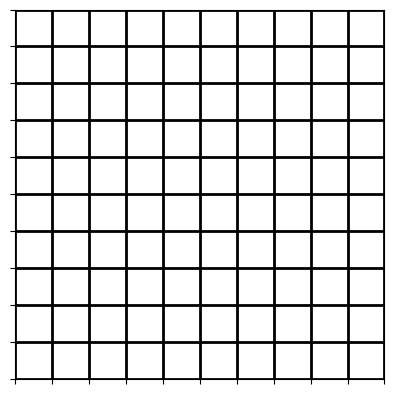

0
[0.26185352 0.27000919 0.24009025 0.22804704]
[0 0 0 0]


In [254]:
report = ucb_reports[report_index]

board = np.array(report["board"])
children_visit_counts = np.array(report["children_visit_counts"])
children_value_sums = np.array(report["children_value_sums"])
children_priors = np.array(report["children_priors"])
array_index_to_move_index = np.array(report["array_index_to_move_index"])
values = np.array(report["values"])
player = report["player"]

Display(board).show()
print(player)
print(values)
print(np.sum(board, axis=(1,2)))

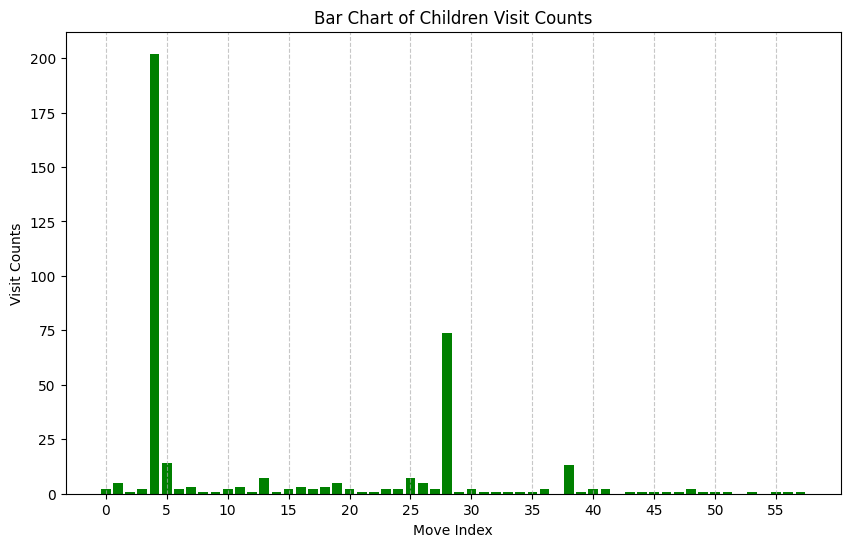

np.int64(400)

In [255]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(children_visit_counts)), children_visit_counts, color='g')
plt.xlabel('Move Index')
plt.ylabel('Visit Counts')
plt.title('Bar Chart of Children Visit Counts')
plt.xticks(ticks=range(0, len(children_visit_counts), max(1, len(children_visit_counts)//10)))
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

sum(children_visit_counts)

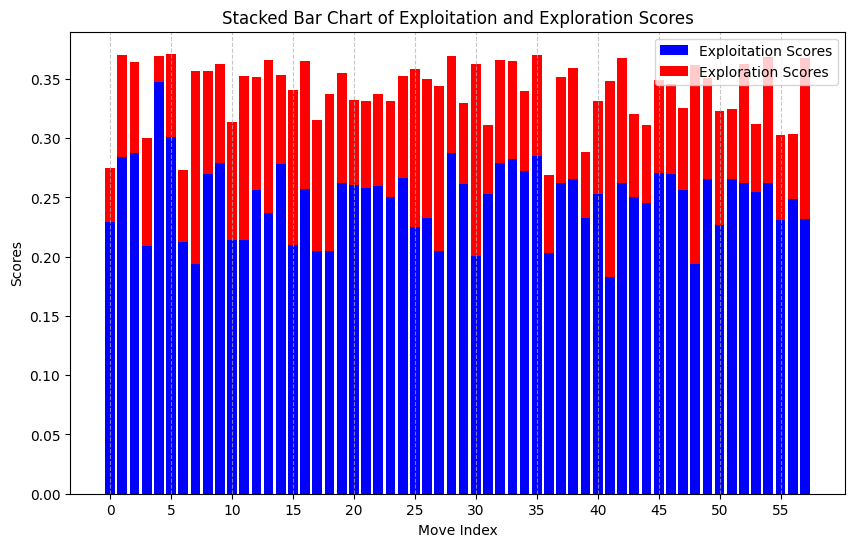

In [256]:
exploitation_scores = np.divide(
    np.array(children_value_sums[player]),
    np.array(children_visit_counts),
    where=children_visit_counts > 0
)
exploitation_scores[children_visit_counts <= 0] = values[player]

sqrt_total_visit_count = np.sqrt(np.sum(children_visit_counts) + 1)
exploration_scores = 1.4 * np.array(children_priors) * sqrt_total_visit_count / (1 + np.array(children_visit_counts))

# Create a stacked bar chart
plt.figure(figsize=(10, 6))
indices = range(len(exploitation_scores))
plt.bar(indices, exploitation_scores, label='Exploitation Scores', color='b')
plt.bar(indices, exploration_scores, bottom=exploitation_scores, label='Exploration Scores', color='r')

plt.xlabel('Move Index')
plt.ylabel('Scores')
plt.title('Stacked Bar Chart of Exploitation and Exploration Scores')
plt.xticks(ticks=range(0, len(exploitation_scores), max(1, len(exploitation_scores)//10)))
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend()
plt.show()


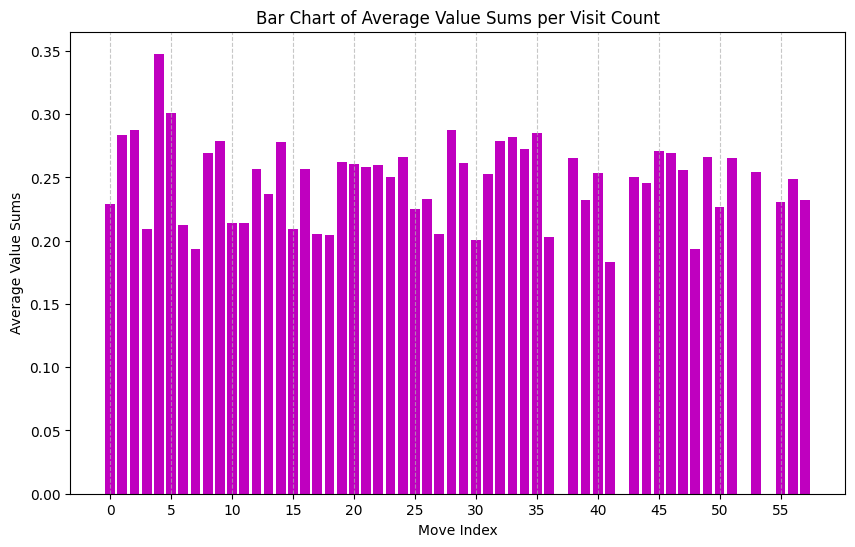

0.26185351610183716


In [257]:
plt.figure(figsize=(10, 6))
average_value_sums = np.array(children_value_sums[player]) / (np.array(children_visit_counts) + 1e-9)  # Avoid division by zero
plt.bar(range(len(average_value_sums)), average_value_sums, color='m')
plt.xlabel('Move Index')
plt.ylabel('Average Value Sums')
plt.title('Bar Chart of Average Value Sums per Visit Count')
plt.xticks(ticks=range(0, len(average_value_sums), max(1, len(average_value_sums)//10)))
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

print(values[player])

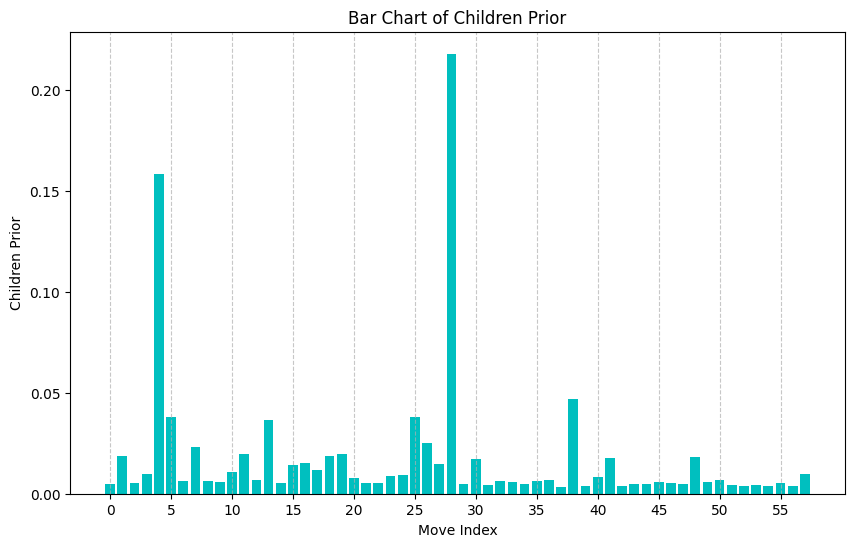

In [258]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(children_priors)), children_priors, color='c')
plt.xlabel('Move Index')
plt.ylabel('Children Prior')
plt.title('Bar Chart of Children Prior')
plt.xticks(ticks=range(0, len(children_priors), max(1, len(children_priors)//10)))
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

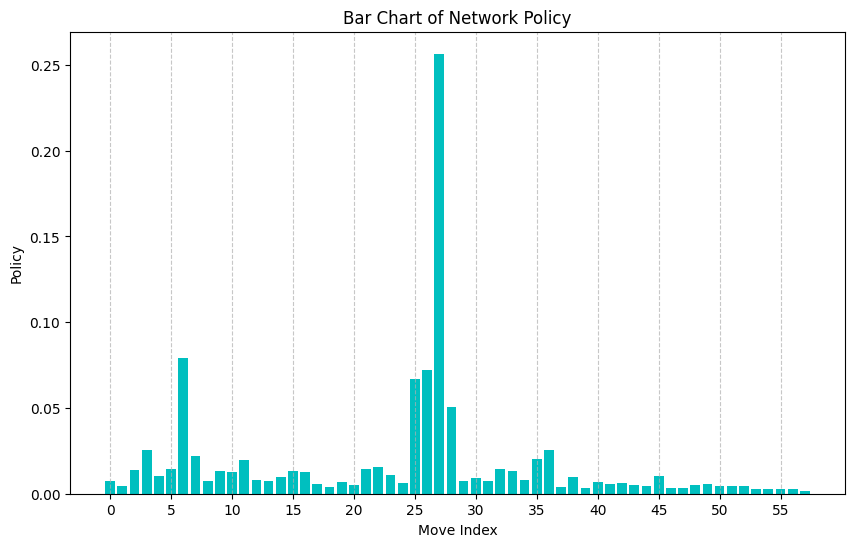

[0.26185352 0.27000919 0.24009025 0.22804704]


In [259]:
model = NeuralNet(config()["networks"]["default"])
# model.load_state_dict(torch.load("../../data/2024-11-19_08-38-28-extracted/models/2024-11-20_09-34-23_478500.pt", weights_only=True))
model.load_state_dict(torch.load("../../data/2024-11-20_17-29-54-solitude/models/2024-11-20_08-24-43_975055.pt", weights_only=True))
# model.load_state_dict(torch.load("../../data/2024-11-20_14-10-24-survival/models/2024-11-20_02-24-48_055438_s105769.pt", weights_only=True))
# model.load_state_dict(torch.load("../../data/2024-11-20_14-10-24-survival/models/2024-11-20_09-34-23_478500_s313486.pt", weights_only=True))

values_logits, policies_logits = model(torch.Tensor(
    player_pov_helpers.occupancies_to_player_pov(board, player)
).unsqueeze(0))

values_logits = values_logits[0].detach().numpy()
policy_logits = policies_logits[0].detach().numpy()

player_pov_values = player_pov_helpers.values_to_player_pov(
    softmax(values_logits),
    -player,
)
policy = softmax(policy_logits[
    player_pov_helpers.moves_indices_to_player_pov(
        array_index_to_move_index,
        player
    )
])

plt.figure(figsize=(10, 6))
plt.bar(range(len(policy)), policy, color='c')
plt.xlabel('Move Index')
plt.ylabel('Policy')
plt.title('Bar Chart of Network Policy')
plt.xticks(ticks=range(0, len(policy), max(1, len(policy)//10)))
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

print(values)

In [260]:
top_10_indices = np.argsort(children_priors)[-10:][::-1]
for i in top_10_indices:
    print(i, np.sum(MOVES["new_occupieds"][i]))

28 5
4 5
38 5
25 5
5 5
13 5
26 5
7 5
19 5
11 5
